In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from color_spaces_functions import *
from Line import *

ImportError: No module named Line

### Import camera calibration matrix to undistort image

In [2]:
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [3]:
img_size = (720, 1280)

In [4]:
# functions used to save images
def export_binary(binary, dst):
    binary_2 = np.dstack((255*binary, 255*binary, 255*binary))
    cv2.imwrite(dst,binary_2)

def write_image(img, dst):
    img_copy = np.copy(img)
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)
    cv2.imwrite(dst,img_copy)

### Undistort images

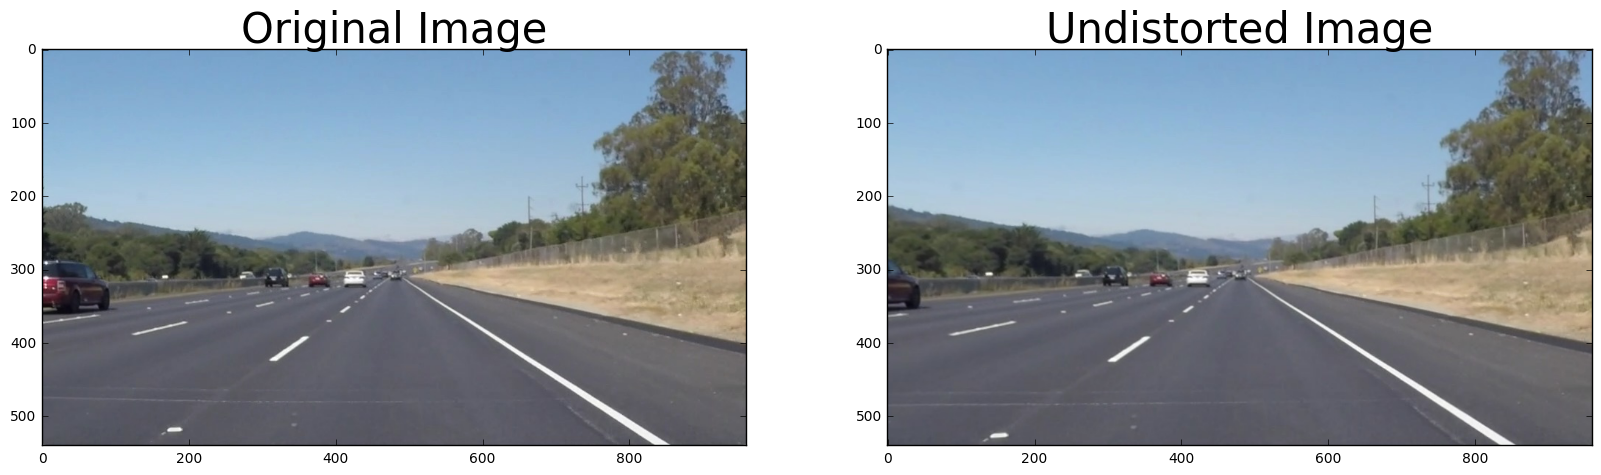

In [5]:
# Visualize undistortion
img = mpimg.imread('test_images/solidWhiteRight.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# write_image(dst, 'output_images/undist_solidWhiteRight.jpg')   

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

### Set up perspective transform for bird view

In [6]:
pt1 = (50,img_size[0])
pt2 = (int(img_size[1] * .4), int(img_size[0]/1.5))
pt3 = (int(img_size[1] * .6), int(img_size[0]/1.5))
pt4 = (int(img_size[1]) - 50, int(img_size[0]))

vertices = np.expand_dims(np.float32([pt1,pt2,pt3,pt4]), axis=0) 
dst = np.float32([[0,img_size[0]], [0,0], [img_size[1],0], [img_size[1],img_size[0]]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(vertices, dst)
# Calculate its inverse as well to unwarp the image
Minv = cv2.getPerspectiveTransform(dst, vertices)

def get_birdeye_view(img):
    result_binary = cv2.resize(img, dsize = (img_size[1], img_size[0]))
    warped = cv2.warpPerspective(result_binary, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR, borderMode = cv2.BORDER_CONSTANT)
    return warped


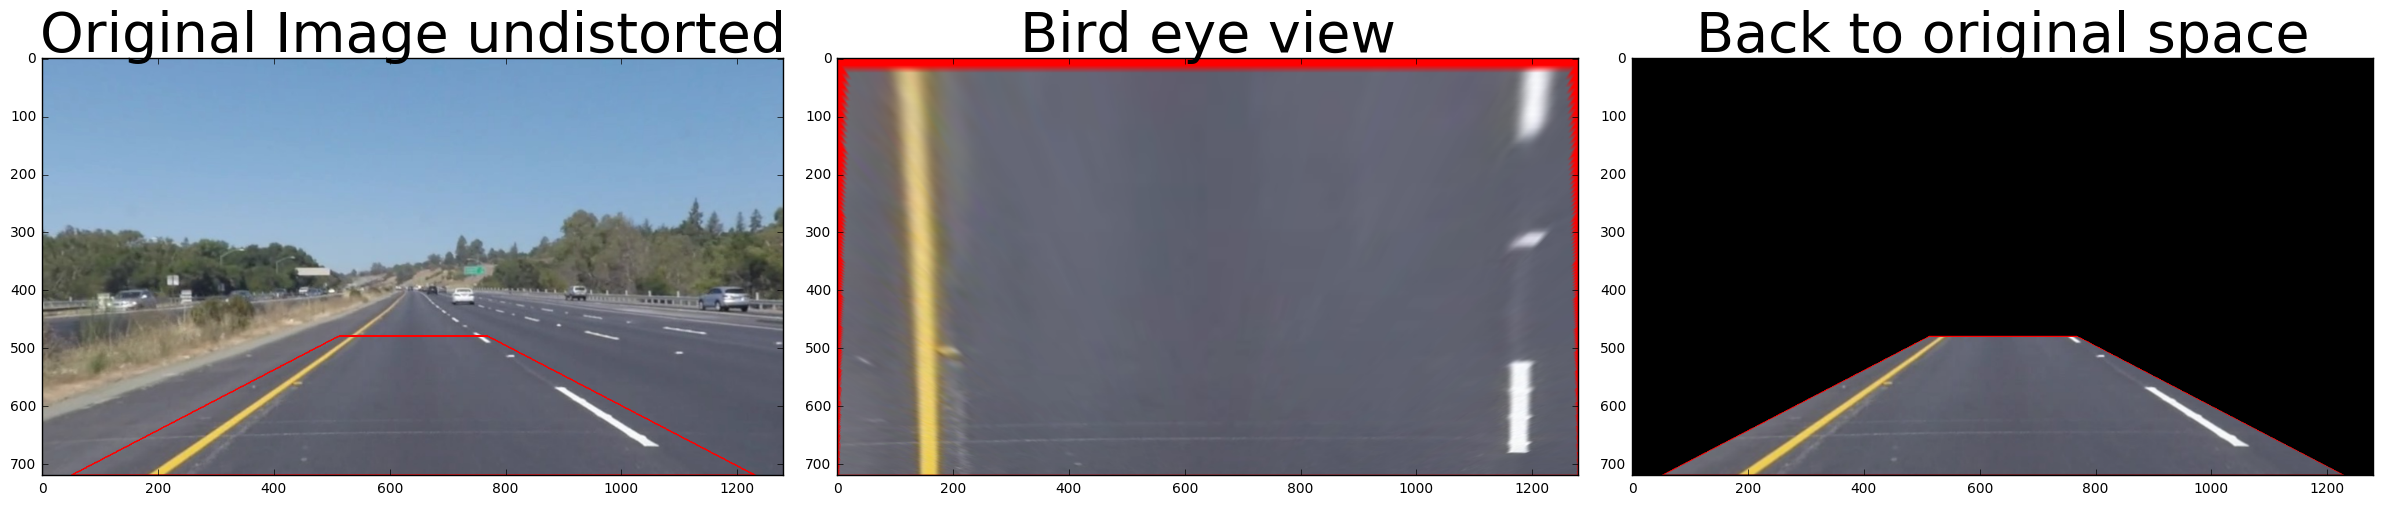

In [7]:
# DEMONSTRATE BIRD VIEW

image = mpimg.imread("test_images/solidYellowLeft.jpg") 
img = cv2.resize(image, dsize = (img_size[1], img_size[0]))
img = cv2.undistort(img, mtx, dist, None, mtx)

cv2.line(img, pt1, pt2, color = (255,0,0), thickness=2)
cv2.line(img, pt2, pt3, color = (255,0,0), thickness=2)
cv2.line(img, pt3, pt4, color = (255,0,0), thickness=2)
cv2.line(img, pt1, pt4, color = (255,0,0), thickness=2)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR, borderMode = cv2.BORDER_CONSTANT)
unwarped = cv2.warpPerspective(warped, Minv, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR, borderMode = cv2.BORDER_CONSTANT)
            
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image undistorted', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Bird eye view', fontsize=40)

ax3.imshow(unwarped)
ax3.set_title('Back to original space', fontsize=40)

plt.show()

# write_image(img, 'output_images/birdeye_original.jpg')   
# write_image(warped, 'output_images/birdeye_warp.jpg')   
# write_image(unwarped, 'output_images/birdeye_unwarp.jpg')   


### Define pipeline to add filters to image

test_images/frame25.jpg


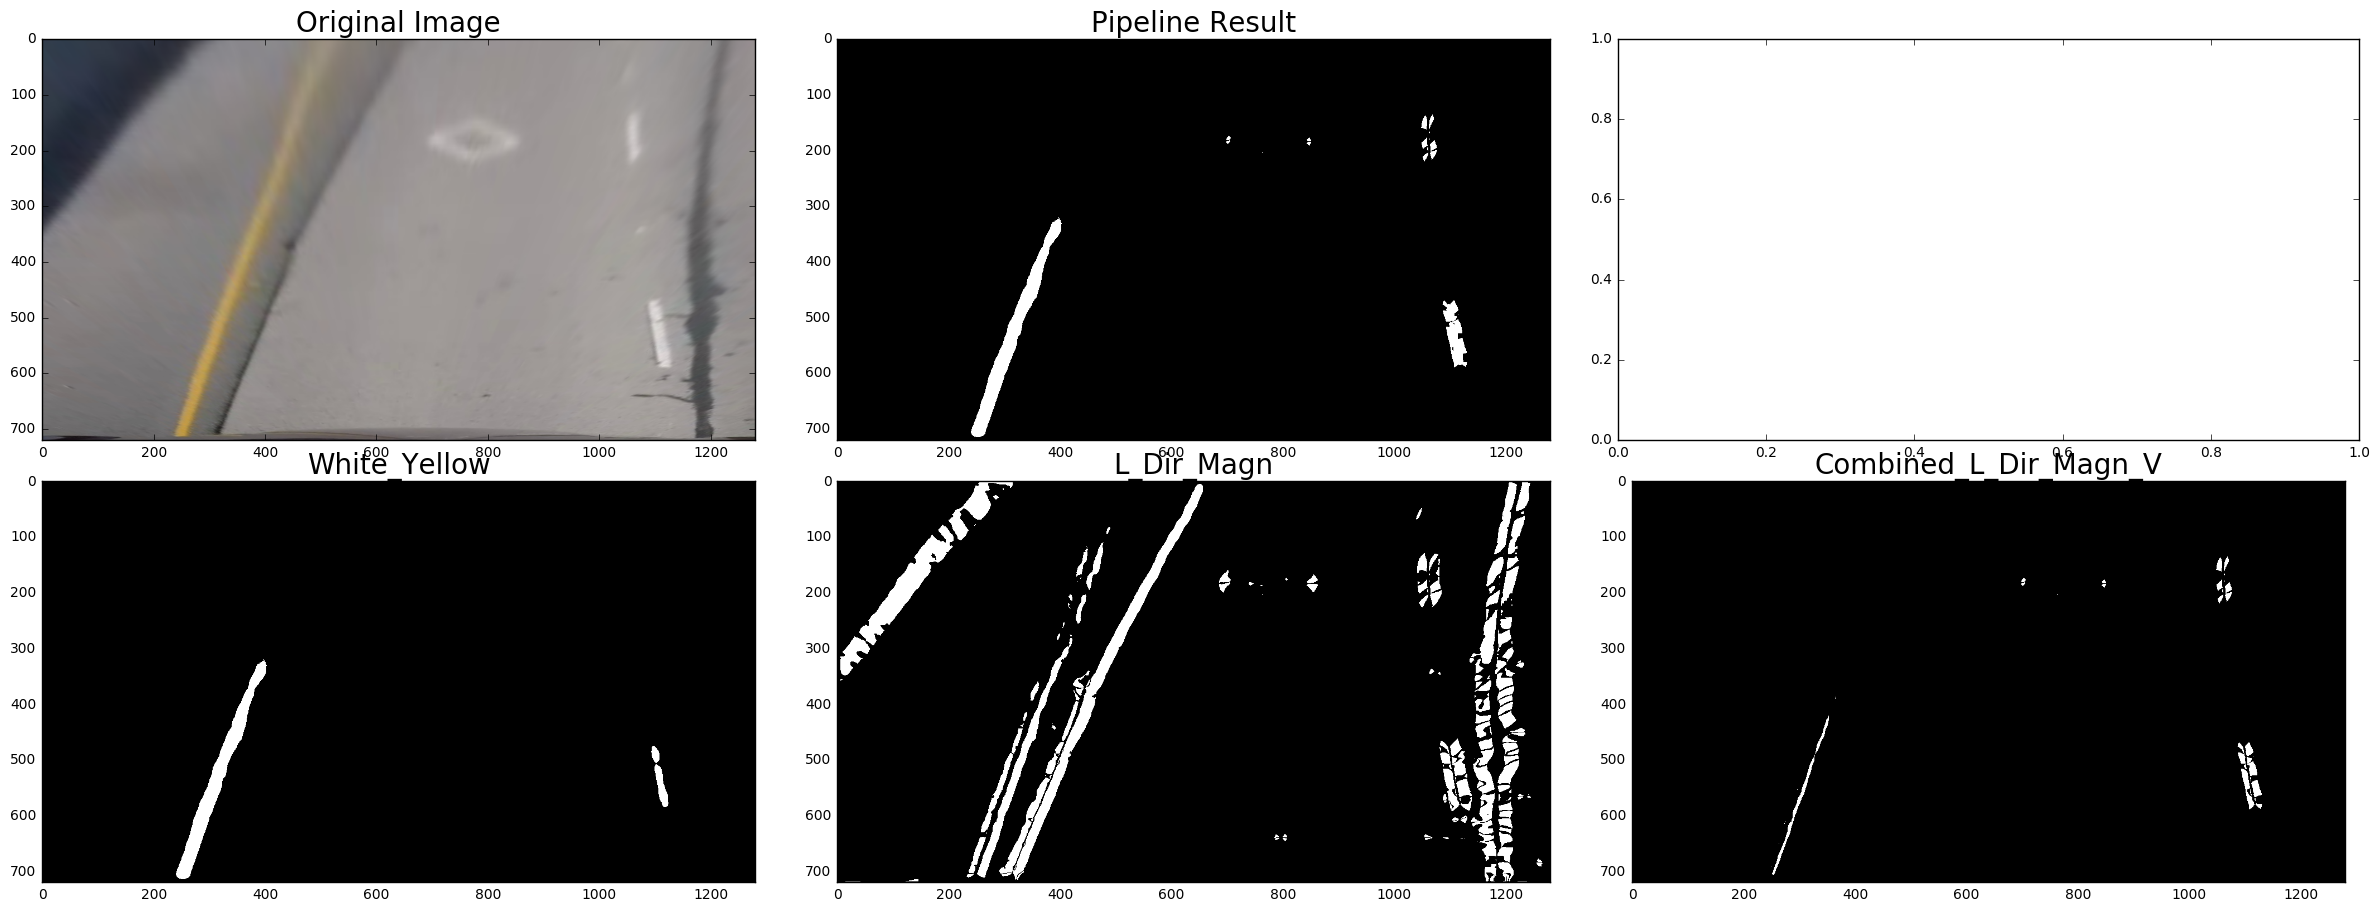

test_images/solidWhiteRight.jpg


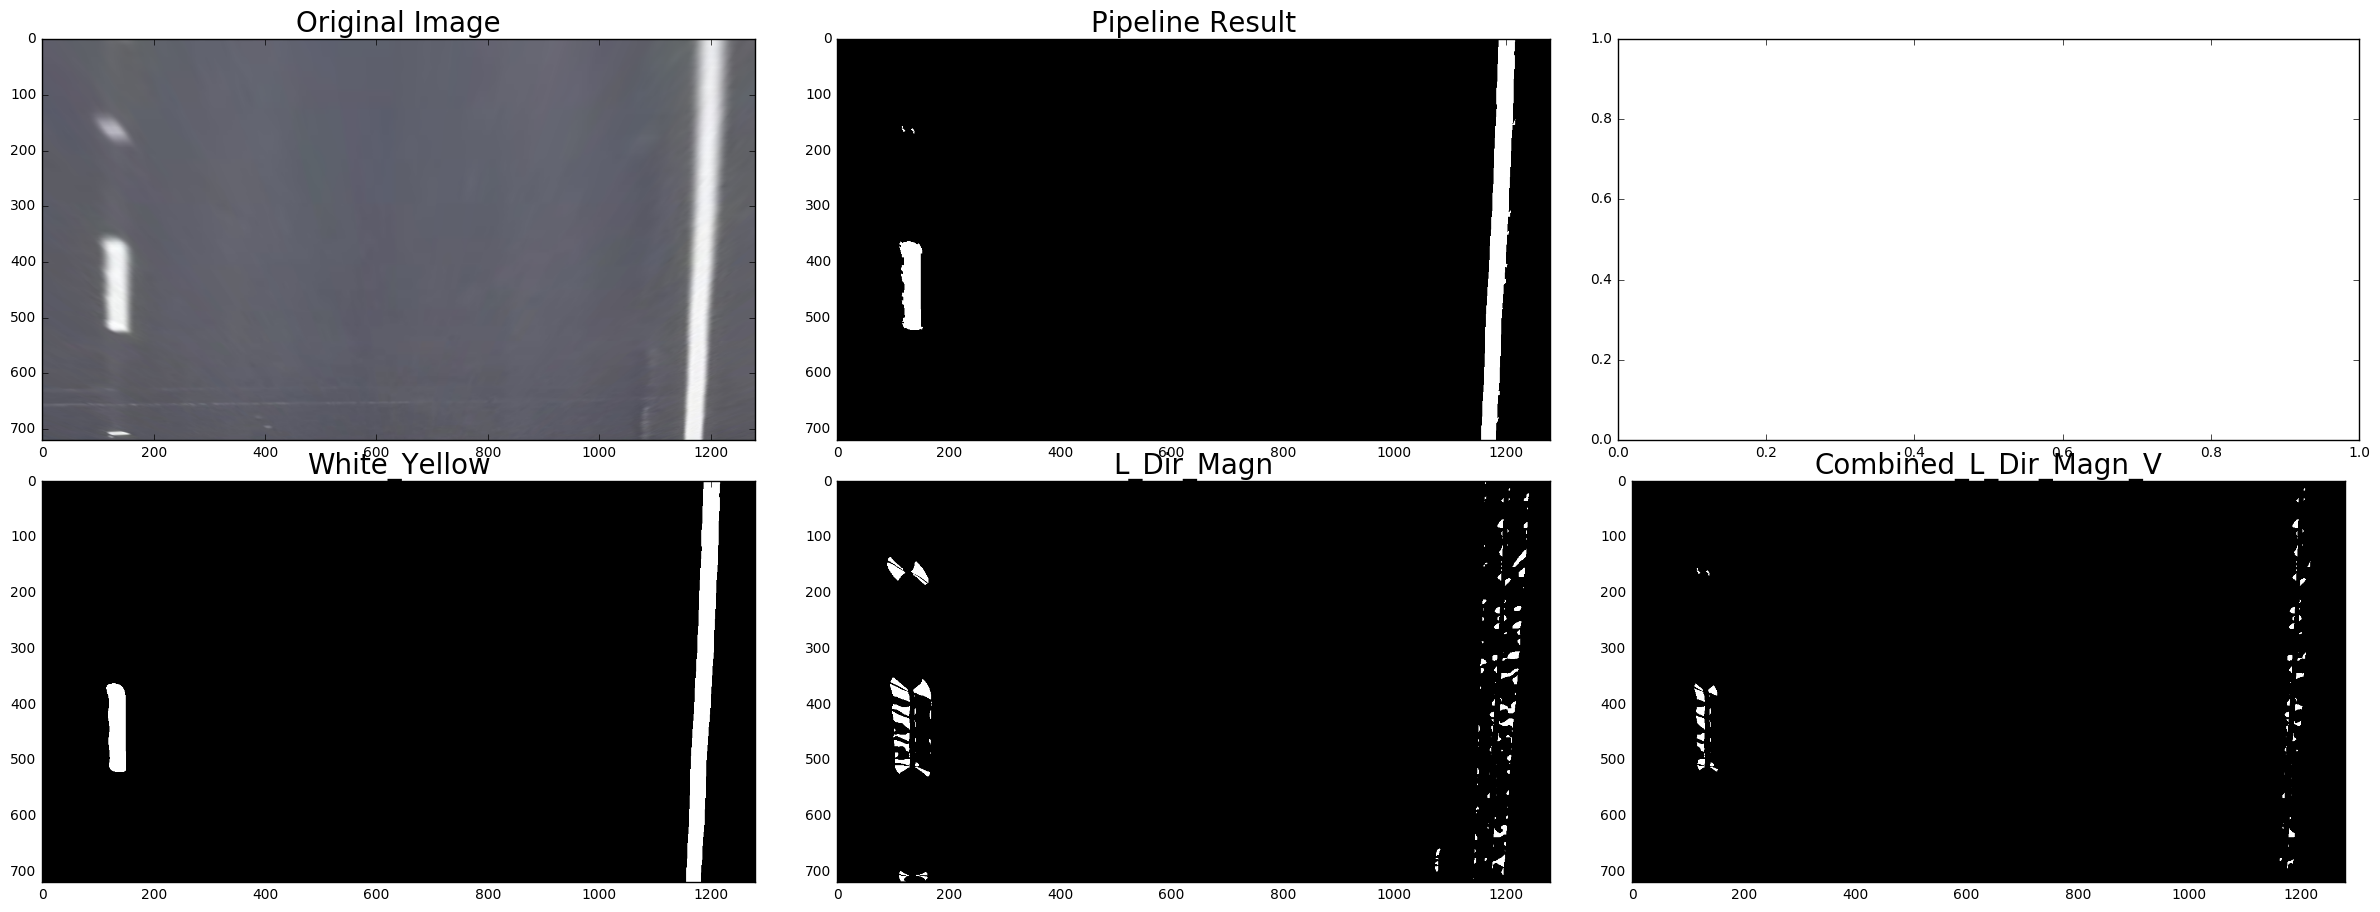

test_images/solidYellowLeft.jpg


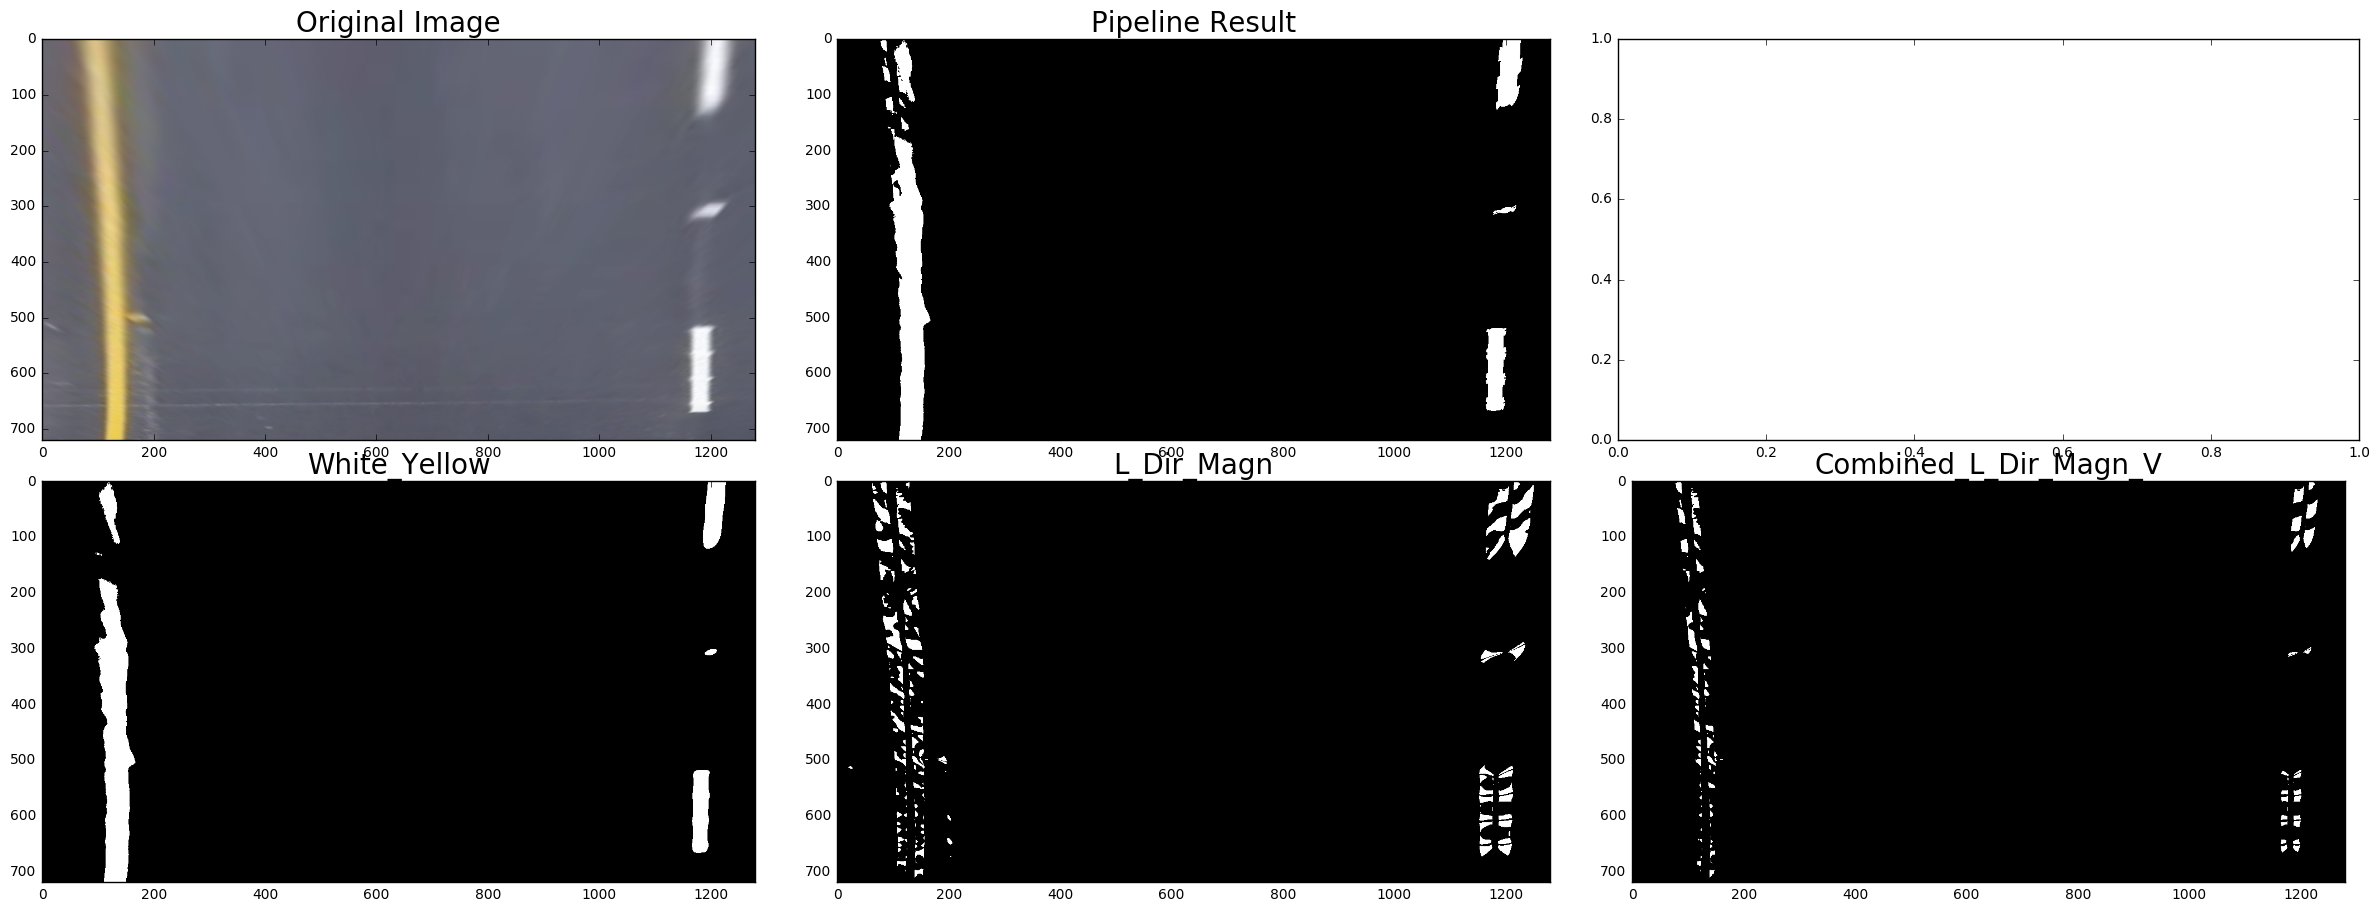

test_images/test1.jpg


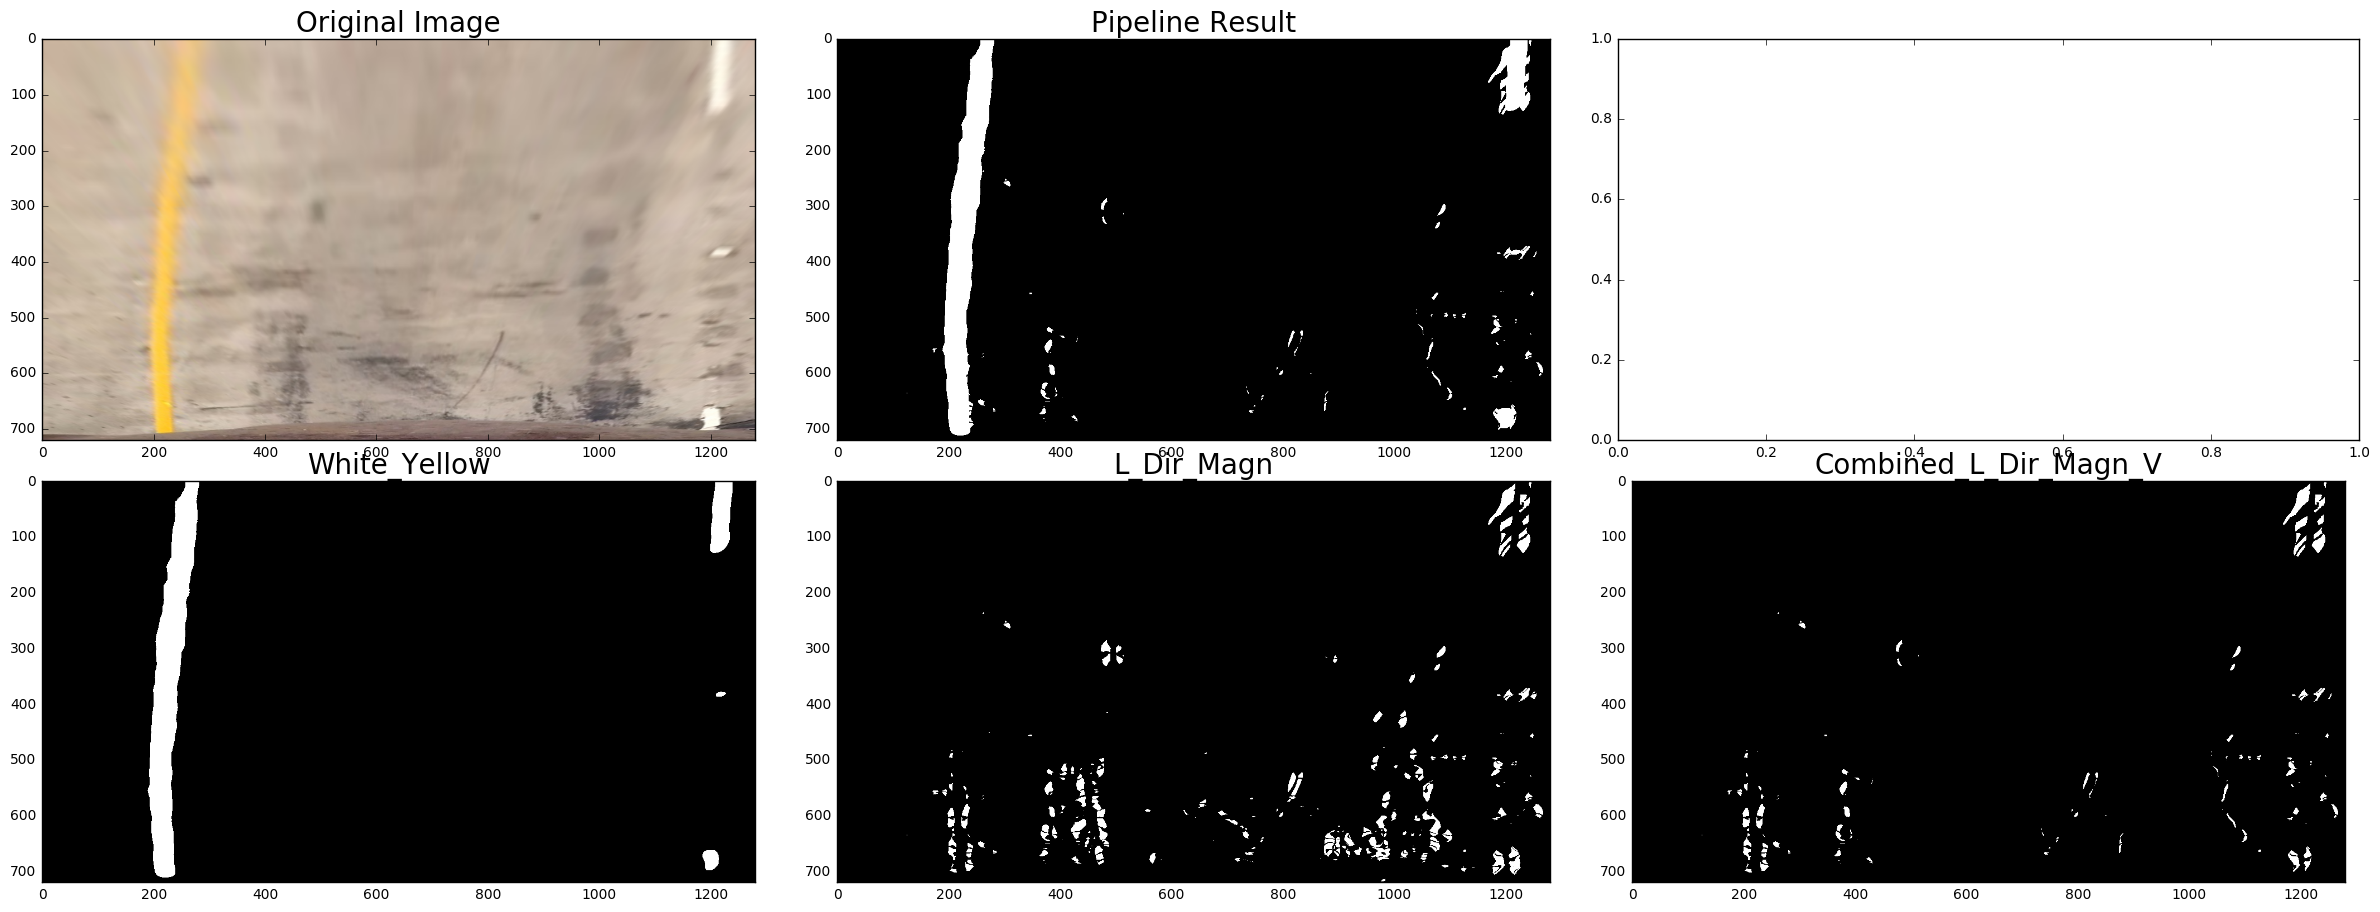

test_images/test2.jpg


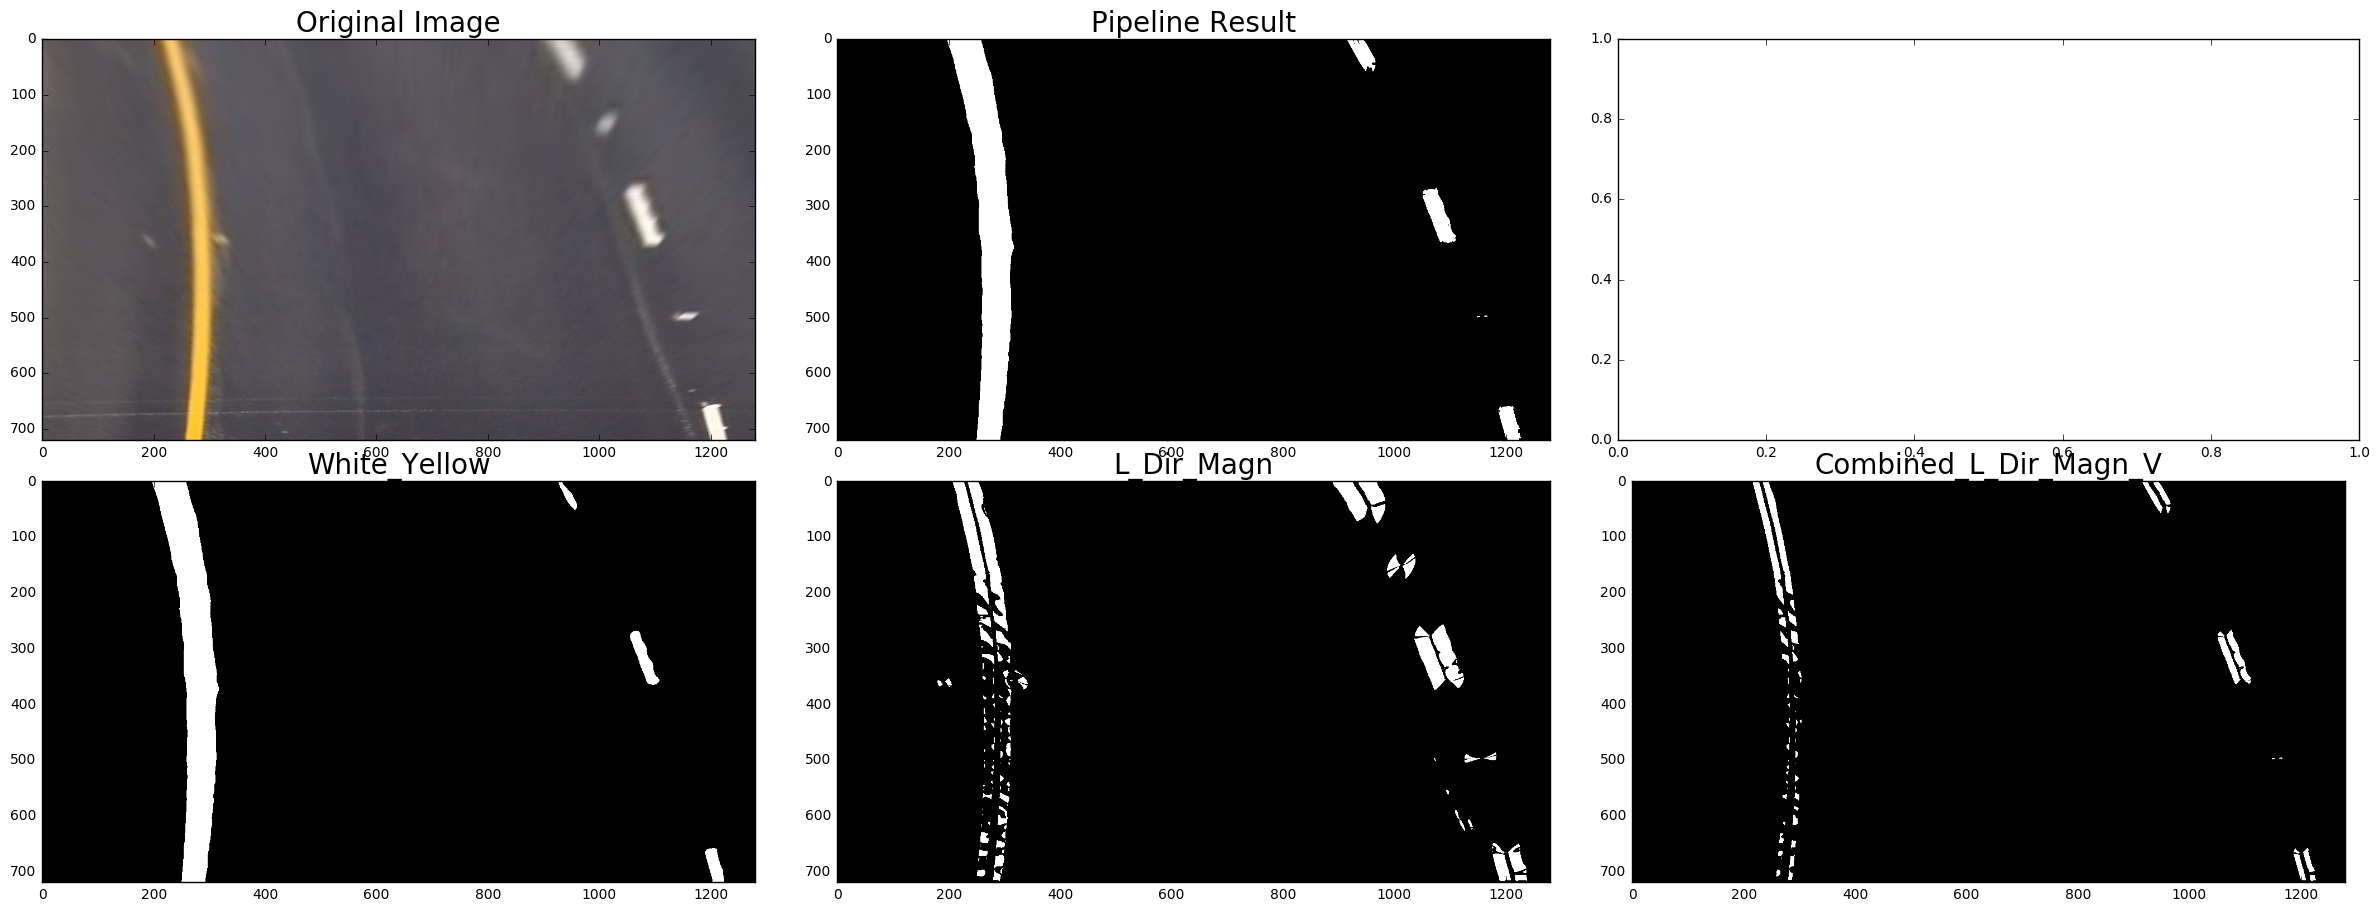

test_images/test3.jpg


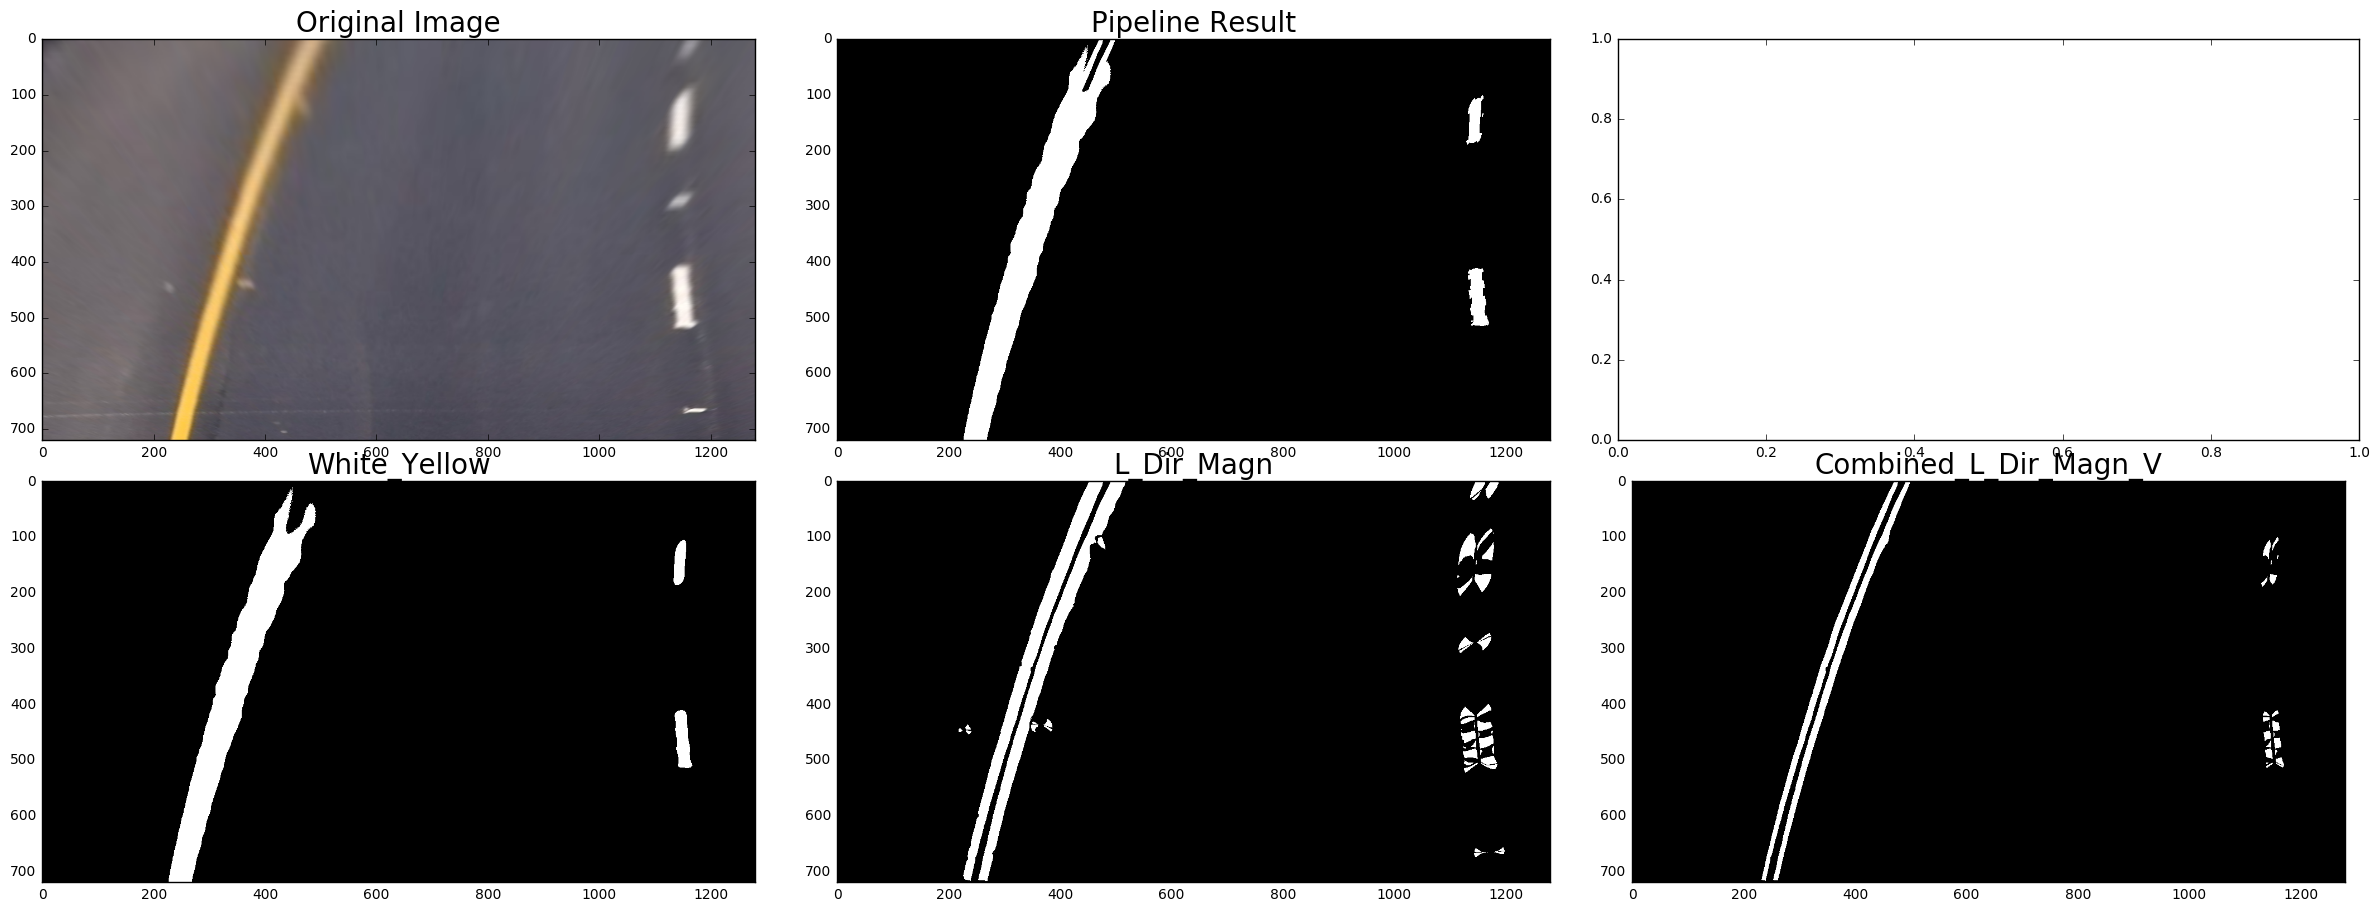

test_images/test4.jpg


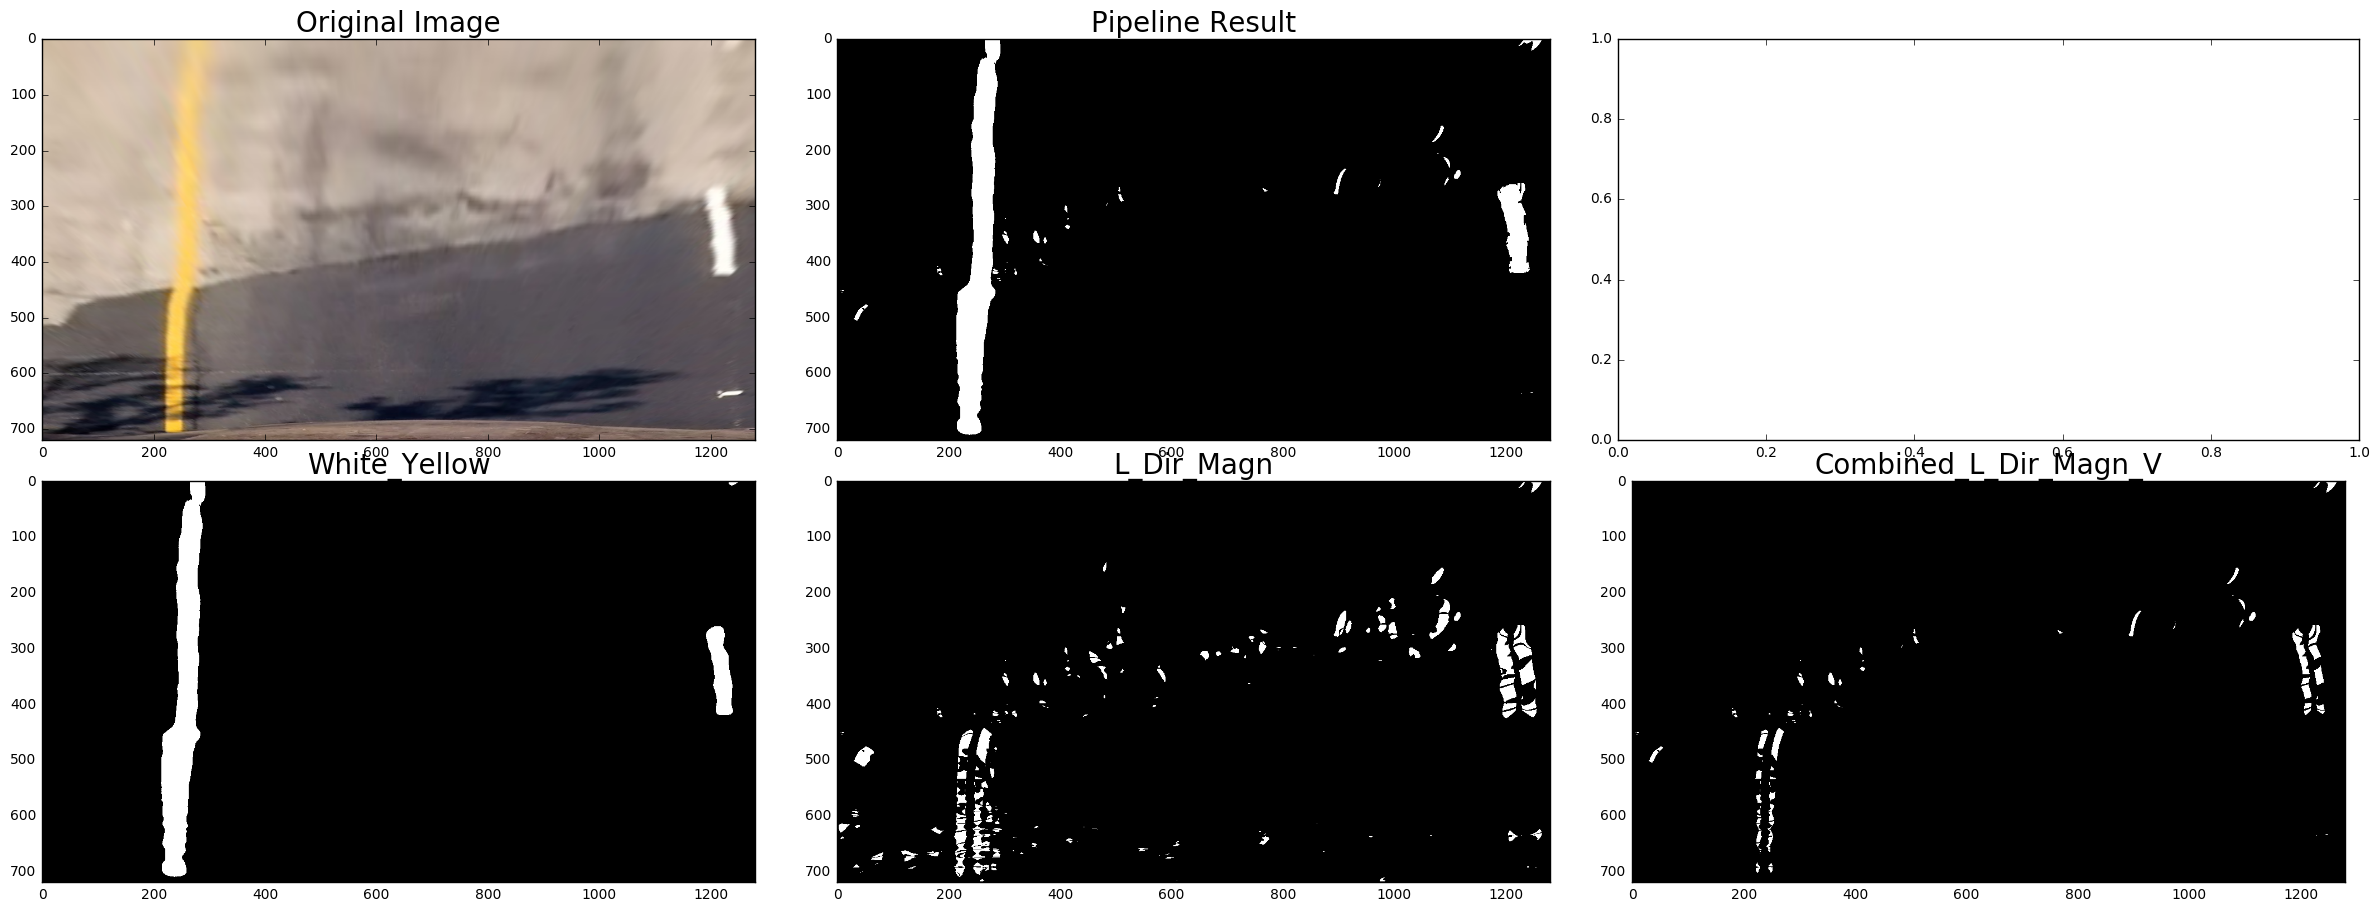

test_images/test5.jpg


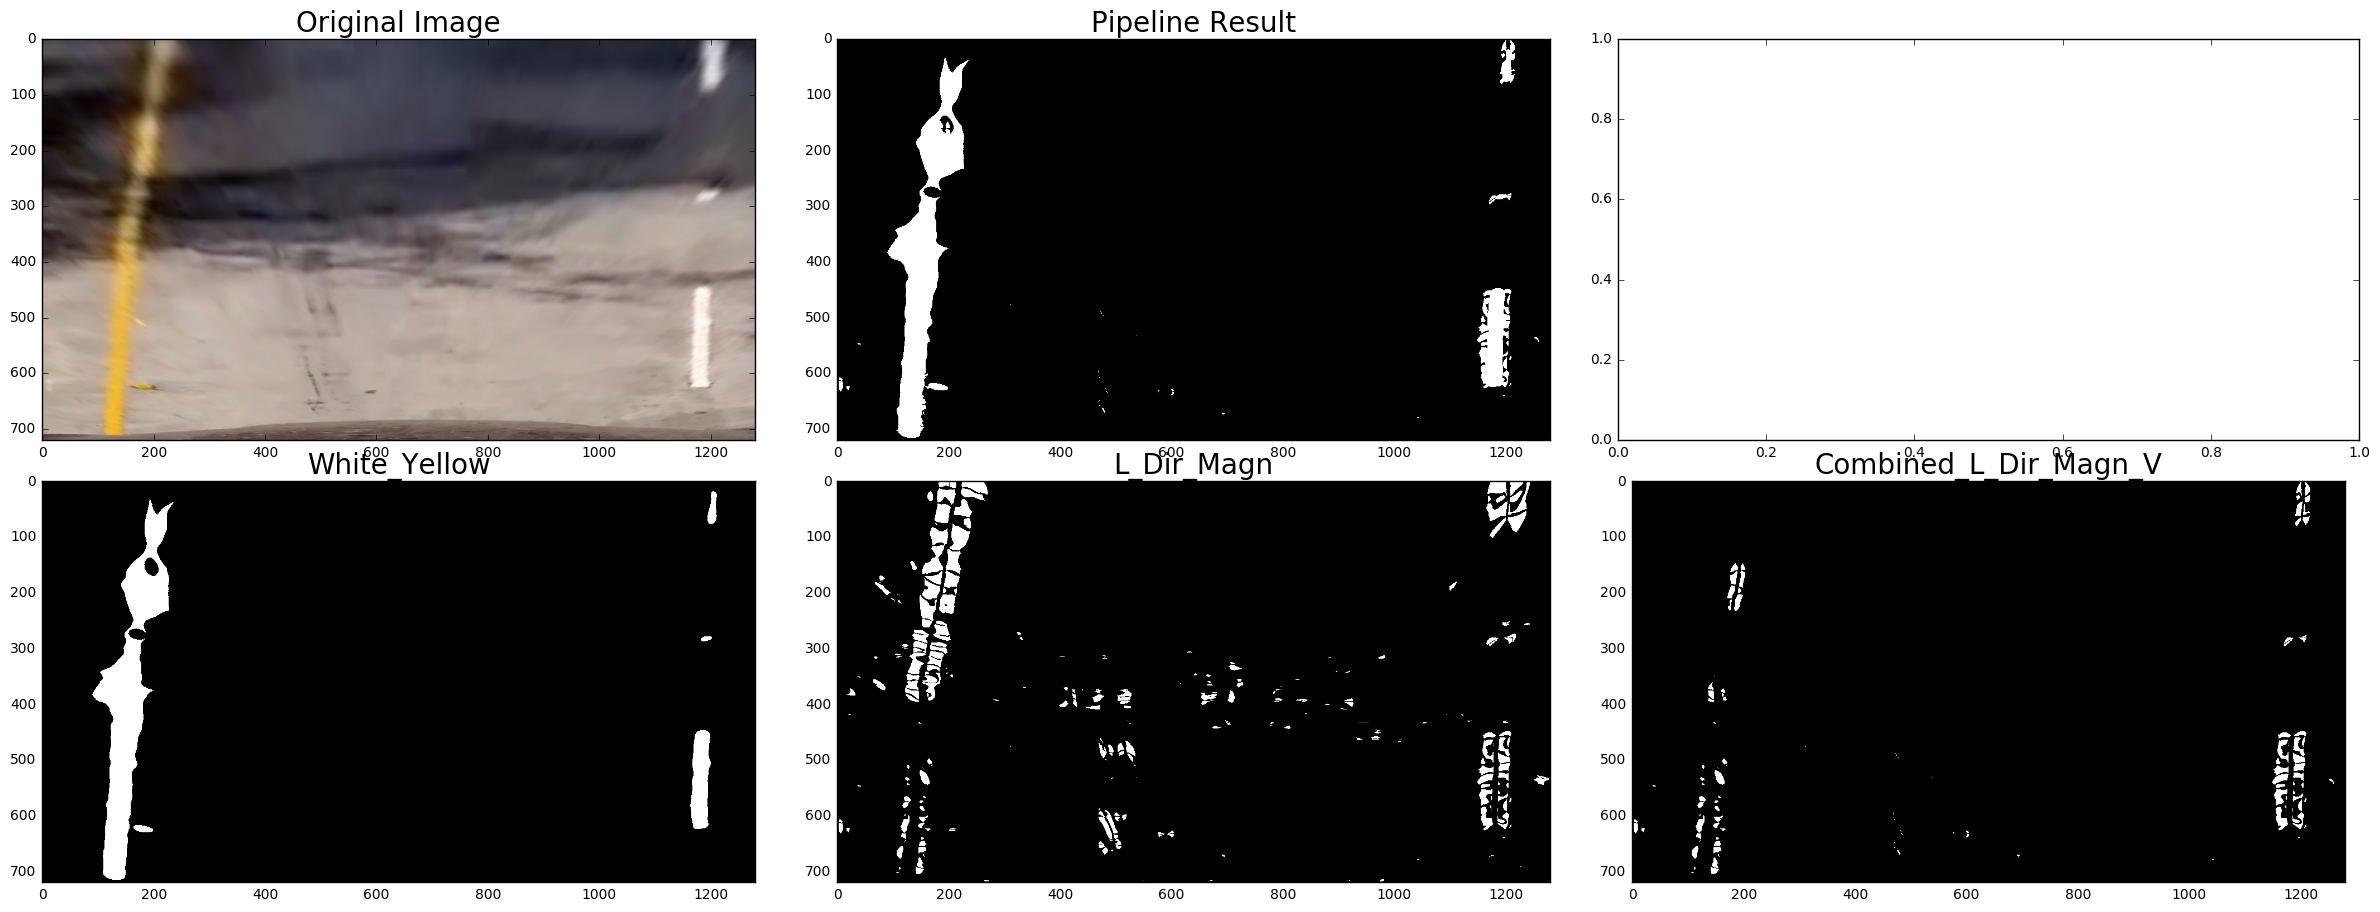

test_images/test6.jpg


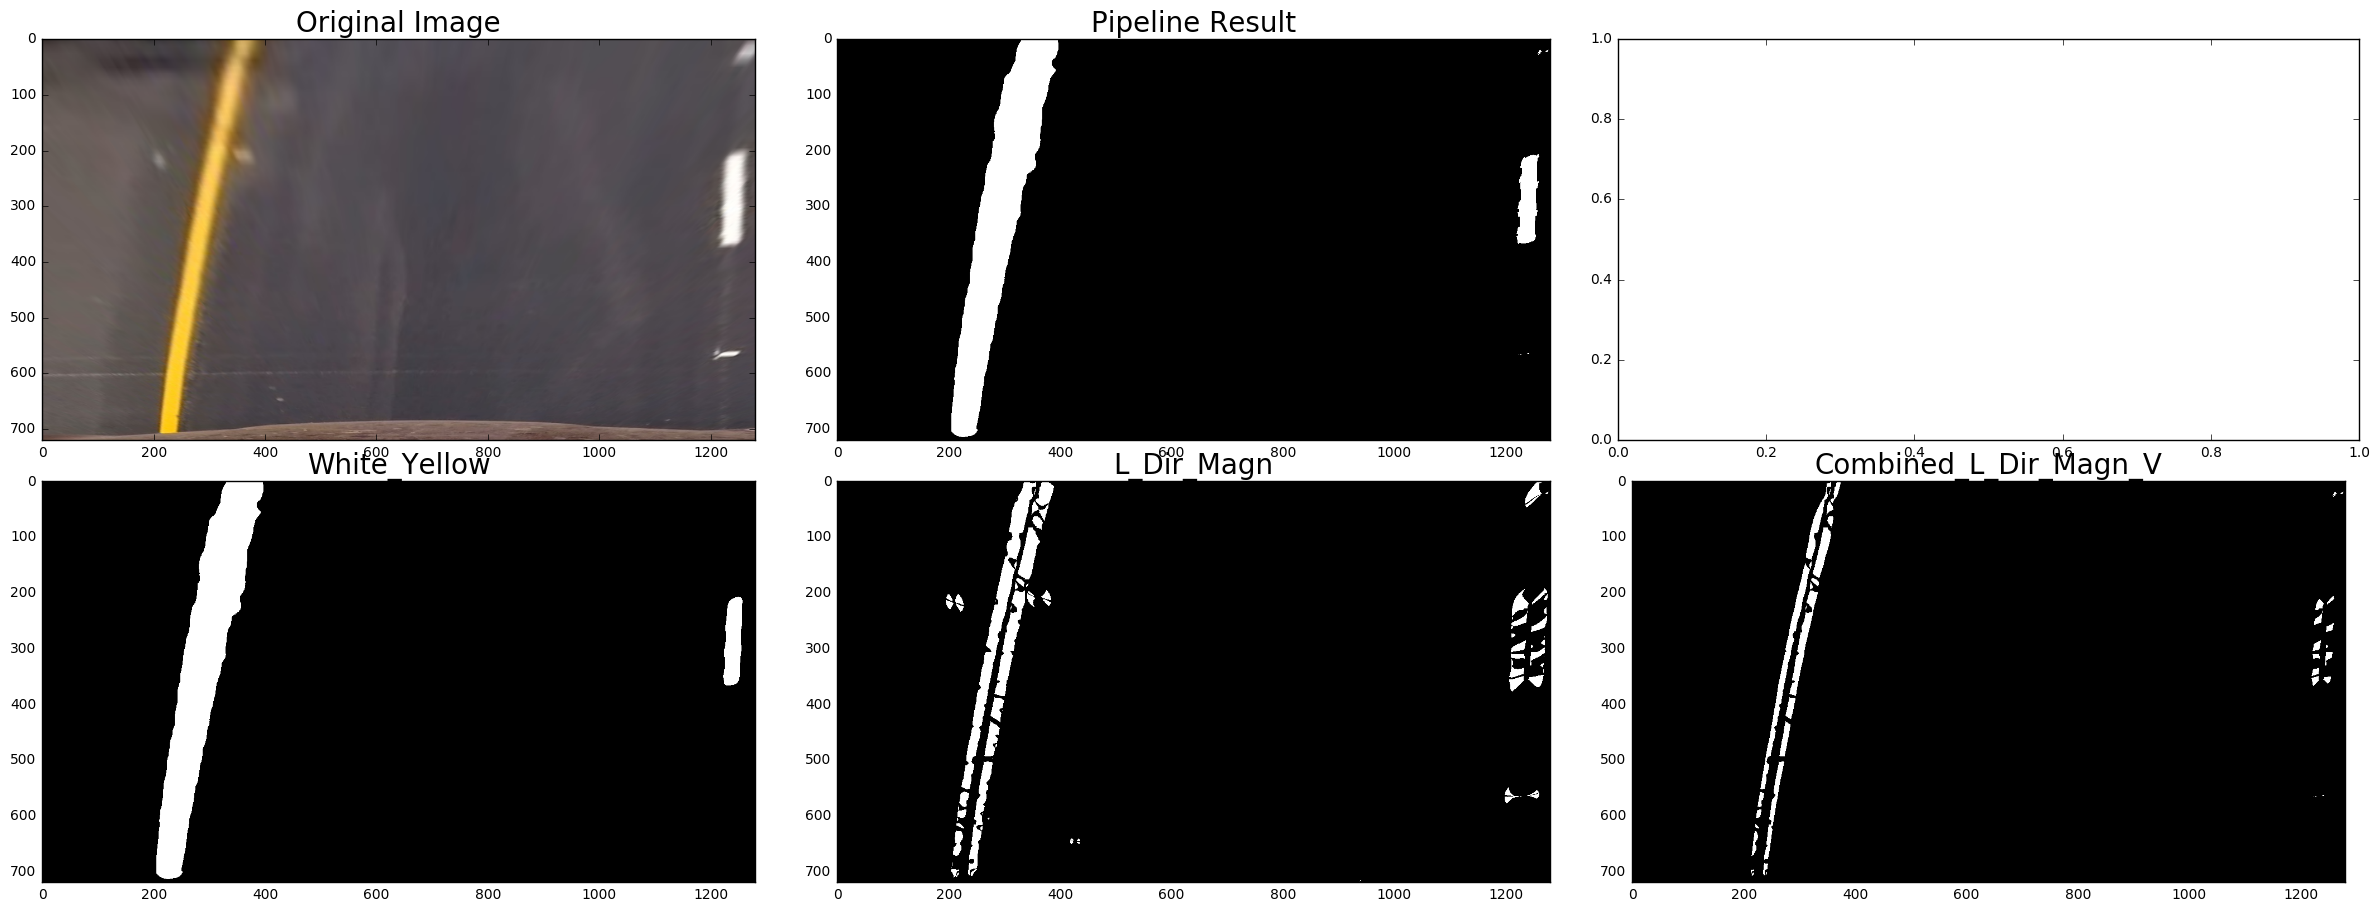

In [8]:
# Edit this function to create your own pipeline.
# !!! Assume the image is ALREADY undistorted
def pipeline(image):
    
    img = np.copy(image)
    img = gaussian_blur(img,25)
        
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
       
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel_hsv = hsv[:,:,0]
    s_channel_hsv = hsv[:,:,1]
    v_channel_hsv = hsv[:,:,2]
        
    lower_yellow  = np.array([ 0,  100,  100])
    upper_yellow = np.array([ 80, 255, 255])

    # Threshold the HSV image to get only yellow colors
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    # Bitwise-AND mask and original image
    res_yellow = cv2.bitwise_and(img,img, mask= mask_yellow).astype(np.uint8)

    lower_white  = np.array([ 200,  200,  200])
    upper_white = np.array([ 255,  255, 255])

    # Threshold the RGB image to get only white colors
    mask_white = cv2.inRange(img, lower_white, upper_white)
    
    # Bitwise-AND mask and original image
    res_white = cv2.bitwise_and(img, img, mask= mask_white).astype(np.uint8)

    mask_white_yellow = cv2.bitwise_or(mask_white, mask_yellow).astype(np.uint8)
    mask_white_yellow_binary = np.zeros_like(mask_white_yellow)
    mask_white_yellow_binary[mask_white_yellow>0] = 1
            
    if DEBUG:
        plt.imshow(mask_white_yellow_binary,cmap = 'gray')
        plt.title('mask_white_yellow_binary')
        plt.show()
    
    if DEBUG:
        # Visualize H, L, S channels together
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 5))
        f.tight_layout()

        ax1.imshow(h_channel, cmap='gray')
        ax1.set_title('H channel', fontsize=15)

        ax2.imshow(l_channel, cmap='gray')
        ax2.set_title('L channel', fontsize=15)

        ax3.imshow(s_channel, cmap='gray')
        ax3.set_title('S channel', fontsize=15)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    
    # L from HLS - sobel (gradient magnitude and direction)
    img_func = l_channel
    ksize = 15
    # Apply each of the thresholding functions
    mag_binary = mag_thresh(img_func, sobel_kernel=ksize, mag_thresh=(30, 255), switch_gray = False)
    dir_binary = dir_threshold(img_func, sobel_kernel=ksize, thresh=(0.1,0.8), switch_gray = False) 
    combined_L1 = np.zeros_like(dir_binary)
    combined_L1[((mag_binary == 1) & (dir_binary > 0))] = 1
    
    if DEBUG:
        plt.imshow(combined_L1, cmap = 'gray')
        plt.title("combined_L1")
        plt.show()
    
    # V from HSV - magnitude
    v_thresh_min_hsv = 180
    v_thresh_max_hsv = 255
    v_binary_hsv = np.zeros_like(v_channel_hsv)
    v_binary_hsv[(v_channel_hsv >= v_thresh_min_hsv) & (v_channel_hsv <= v_thresh_max_hsv)] = 1
    if DEBUG:
        plt.imshow(v_binary_hsv, cmap = 'gray')
        plt.title('v_binary_hsv')
        plt.show()

        
    # combine V from HSV - magnitude and L from HLS - sobel (gradient magnitude and direction)
    combined_L1_V = np.zeros_like(dir_binary)
    combined_L1_V[((combined_L1 == 1) & (v_binary_hsv > 0))] = 1
     
    if DEBUG:
        plt.imshow(combined_L1_V, cmap = 'gray')
        plt.title("combined_L1_V")
        plt.show()

    # combine with white and yellow mask:
    combined_SLGXS = np.zeros_like(mask_white_yellow_binary)    
    combined_SLGXS[(mask_white_yellow_binary == 1) | (combined_L1_V == 1)] = 1 
     
    return combined_SLGXS, mask_white_yellow_binary, combined_L1, combined_L1_V

images = glob.glob('test_images/*.jpg')
DEBUG = False;

# Step through the list of test images
for idx, fname in enumerate(images):
    if True: #fname == 'test_images/frame25.jpg'
        print(fname)
        img = mpimg.imread(fname)
        img = cv2.undistort(img, mtx, dist, None, mtx)
        img = get_birdeye_view(img) 
        
        result_binary, mask_white_yellow_binary, combined_L1, combined_L1_V = pipeline(img)

        # Plot the result
        f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)

        ax2.imshow(result_binary, cmap = 'gray')
        ax2.set_title('Pipeline Result', fontsize=20)
        
        ax4.imshow(mask_white_yellow_binary, cmap = 'gray')
        ax4.set_title('White_Yellow', fontsize=20)
        
        ax5.imshow(combined_L1, cmap = 'gray')
        ax5.set_title('L_Dir_Magn', fontsize=20)
        
        ax6.imshow(combined_L1_V, cmap = 'gray')
        ax6.set_title('Combined_L_Dir_Magn_V', fontsize=20)
        
        plt.show()
        
# write_image(img, 'output_images/masks_pipeline_original_img.jpg')   
# export_binary(binary = result_binary, dst = 'output_images/masks_pipeline_result.jpg')
# export_binary(binary = mask_white_yellow_binary, dst = 'output_images/masks_yellow_white.jpg')
# export_binary(binary = combined_L1, dst = 'output_images/masks_L_Dir_Magn.jpg')
# export_binary(binary = combined_L1_V, dst = 'output_images/masks_L_Dir_Magn_V.jpg')

        

### Identify the lines

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # for how many iterations was the lane not dectected
        self.undetected_ct = 0  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients of the last n iterations
        self.recent_best_fit = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in meters
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.framect = 0  
        #y values for detected line pixels


In [10]:
_N_ = 10 #average the values for the last _N_ lines
_MIN_PIXELS_ = 500 # enough pixels to identify a line
ym_per_pix = 12/720 # meters per pixel in y dimension
xm_per_pix = 3.7/1000 # meters per pixel in x dimension
_MAX_RADIUS_RATIO_ = 10

In [11]:
def identify_lane_from_existing(birdeye_img, lane_record = None):
    
    if lane_record is None:
        return None
    
    else:
    
        # get the points needed: 
        side_lane = np.copy(birdeye_img)

        yvals = np.arange(10)*img_size[0]/10 + 72/2
        side_fitx = lane_record.best_fit[0]*yvals**2 + lane_record.best_fit[1]*yvals + lane_record.best_fit[2]

        existing_mask = np.ones(shape = (birdeye_img.shape[0], birdeye_img.shape[1]))
        for i in range(10):
            existing_mask[int(i*side_lane.shape[0]/10):int((i+1)*side_lane.shape[0]/10),:int(side_fitx[i]) - 25] = 0
            existing_mask[int(i*side_lane.shape[0]/10):int((i+1)*side_lane.shape[0]/10),int(side_fitx[i]) + 25:] = 0

        for i in range(10):
            side_lane[int(i*side_lane.shape[0]/10):int((i+1)*side_lane.shape[0]/10),:int(side_fitx[i]) - 25] = 0
            side_lane[int(i*side_lane.shape[0]/10):int((i+1)*side_lane.shape[0]/10),int(side_fitx[i]) + 25:] = 0

        if DEBUG:

            f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
            # export_binary(binary = birdeye_img, dst = 'output_images/identify_lane_v2_birdeyeimage.jpg')
            ax1.imshow(birdeye_img, cmap = 'gray')
            ax2.set_title("Birdeye Image")
            # export_binary(binary = existing_mask, dst = 'output_images/identify_lane_v2_existing_mask.jpg')
            ax2.imshow(existing_mask, cmap = 'gray')
            ax2.set_title("Existing Mask")
            # export_binary(binary = side_lane, dst = 'output_images/identify_lane_v2_identified_lane.jpg')
            ax3.imshow(side_lane, cmap = 'gray')
            ax3.set_title("Identified Lane")
            plt.show()

        return side_lane

#_ = identify_lane_from_existing(birdeye_img, lane = 'left', lane_record = None)

In [12]:
def identify_lane(birdeye_img, lane = 'left', lane_record = None):
    birdeye_img = gaussian_blur(birdeye_img,11)
    is_hist = True
    
    # if there are enough values in the lane record and the last lane was detected, look for a new line around the existing one.
    if (lane_record is not None and lane_record != None and len(lane_record.recent_xfitted) >= _N_ and lane_record.undetected_ct == 0):
        if DEBUG:
            print('identify_lane: Using existing values')
        side_lane = identify_lane_from_existing(birdeye_img, lane_record = lane_record)
        is_hist = False
    
    else:
        
        if DEBUG:
            print('identify_lane: Running histogram search')
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))            
            
            # export_binary(binary = birdeye_img, dst = 'output_images/identify_lane_orgininal_mask.jpg')
            ax1.imshow(birdeye_img, cmap = 'gray')

        histogram = np.mean(birdeye_img[int(birdeye_img.shape[0]/2):,:], axis=0)

        if DEBUG:
            ax2.plot(histogram)
            plt.show()

        center_point = int(birdeye_img.shape[1]/2)

        histogram_side = np.copy(histogram)
        if lane == 'left':
            histogram_side[center_point:] = 0
        else:
            histogram_side[:center_point] = 0

        argmax_histogram_side = np.argmax(histogram_side)
        
        if histogram_side[argmax_histogram_side] < 0.01:
            if lane == 'left':
                side_min_lane_detected = 100
                side_max_lane_detected = 500
            if lane == 'right':
                side_min_lane_detected = 800
                side_max_lane_detected = 1200
        
        else :
            side_min_lane_detected = argmax_histogram_side - 50 
            side_max_lane_detected = argmax_histogram_side + 50 
      
        # PROGRESSIVELY IDENTIFY THE LINE
        birdeye_img_copy = np.copy(birdeye_img)
        side_ranges = np.ndarray(shape=(8,2), dtype=float)
        side_range_min = side_min_lane_detected
        side_range_max = side_max_lane_detected

        # redo a histogram within the range
        for i in range(8): 
            
            lower_part = birdeye_img_copy[int((7-i)*birdeye_img.shape[0]/8):int((7-i+1)*birdeye_img.shape[0]/8),:]
            lower_part[:,:side_range_min] = 0
            lower_part[:,side_range_max:] = 0
            hist = np.mean(lower_part, axis = 0)
            avgpoint = np.argmax(hist)
            if(hist[avgpoint] > .1):
                side_range_min = max(0,avgpoint - 50)
                side_range_max = min(img_size[1], avgpoint + 50)
            else:
                side_range_min = max(0,side_range_min - 50)
                side_range_max = min(img_size[1],side_range_max + 50)
            side_ranges[7-i] = [side_range_min, side_range_max]
            
            if DEBUG:
                plt.subplot(8,1,8-i)
                plt.plot(hist)
                plt.tick_params(axis='both', top='off', right='off', bottom='off', labeltop='off', labelright='off', labelbottom='off')

        if DEBUG:
            plt.show()

        # SELECT ONLY THE PIXELS IDENTIFIED ABOVE
        side_lane = np.copy(birdeye_img)
        for i in range(8):
            side_lane[int(i*side_lane.shape[0]/8):int((i+1)*side_lane.shape[0]/8),:int(side_ranges[i][0])] = 0
            side_lane[int(i*side_lane.shape[0]/8):int((i+1)*side_lane.shape[0]/8),int(side_ranges[i][1]):] = 0
        
        
    # FIT LANE
    side_lane[side_lane > .5] = 1
    side_lane[side_lane < .5] = 0

    vals = np.argwhere(side_lane>.5)
    sidex = vals.T[1]
    sideyvals = vals.T[0]

    if len(sideyvals) >= _MIN_PIXELS_: # enough pixels to identify a line
        side_fit = np.polyfit(sideyvals, sidex, 2)
    else:
        side_fit = None
    
    # export_binary(binary = side_lane, dst = 'output_images/identify_lane_side_lane.jpg')
    
    return side_fit, sideyvals, sidex, is_hist


identify_lane: Running histogram search


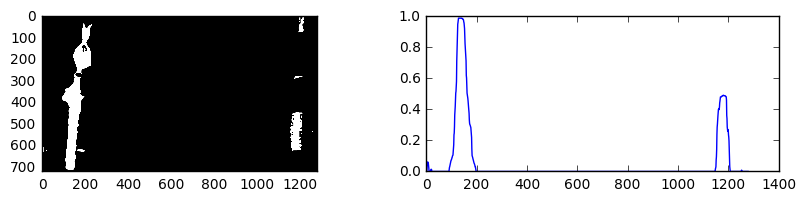

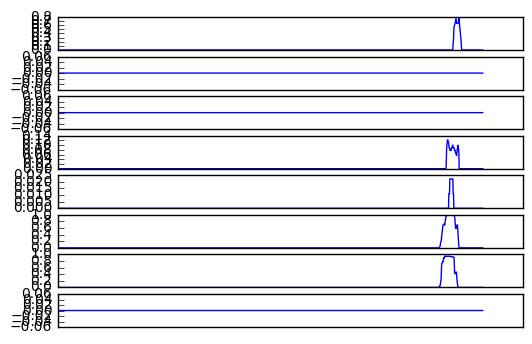

identify_lane: Running histogram search


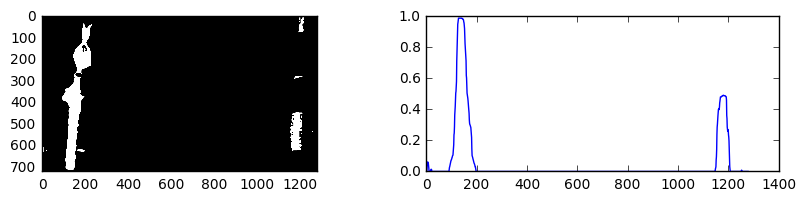

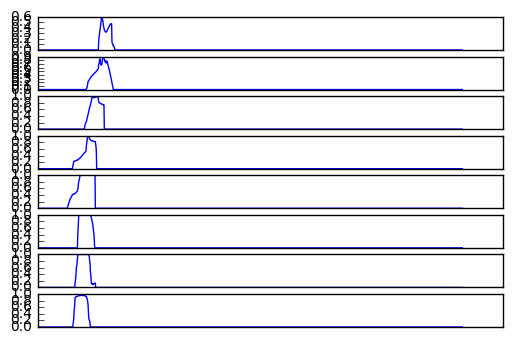

In [13]:
########## RUN IT
DEBUG = False
img = mpimg.imread('test_images/test5.jpg')
img_undistort = cv2.undistort(img, mtx, dist, None, mtx)
img_birdeye = get_birdeye_view(img_undistort) 
img_filter, _, _, _ = pipeline(img_birdeye)
DEBUG = True
right_fit, rightyvals, rightx, is_hist = identify_lane(img_filter, lane = 'right')
left_fit, leftyvals, leftx, is_hist = identify_lane(img_filter, lane = 'left')


In [14]:
def get_curb(fit, sideyvals, sidex):
    if (fit is None or sideyvals is None or sidex is None):
        return None, None
    
    y_eval = img_size[0]
    #side_curverad_px = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) \
    #                             /np.absolute(2*fit[0])    
    side_line_position_px = fit[0]*y_eval**2 + fit[1]*y_eval + fit[2]
     
    y_eval = img_size[0]/2
    side_fit_cr = np.polyfit(sideyvals*ym_per_pix, sidex*xm_per_pix, 2) 
    side_curverad_meters = ((1 + (2*side_fit_cr[0]*y_eval + side_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*side_fit_cr[0])
    
    # Now our radius of curvature is in meters
    if DEBUG:
        print(int(side_curverad_meters), 'm')

    return side_curverad_meters, side_line_position_px

def get_best_curb(lane_record):
    if (lane_record is None or lane_record.best_fit is None):
        return None
    
    y_eval = img_size[0]/2
    
    yvals = np.arange(11)*img_size[0]/10
    side_fitx = lane_record.best_fit[0]*yvals**2 + lane_record.best_fit[1]*yvals + lane_record.best_fit[2]

    y_eval = img_size[0]
    side_line_position_px = lane_record.best_fit[0]*y_eval**2 + lane_record.best_fit[1]*y_eval + lane_record.best_fit[2]
    
    y_eval = img_size[0]/2
    side_fit_cr = np.polyfit(yvals*ym_per_pix, side_fitx*xm_per_pix, 2) 
    side_curverad_meters = ((1 + (2*side_fit_cr[0]*y_eval + side_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*side_fit_cr[0])
    
    # Now our radius of curvature is in meters
    if DEBUG:
        print(int(side_curverad_meters), 'm')

    return side_curverad_meters, side_line_position_px


def get_car_position(side_line_position):
    car_position_px = abs(img_size[1]/2 - side_line_position)   #pixels between left line and the center of the car i.e. center of x-axis   
    car_position_meters = car_position_px * xm_per_pix    
    return car_position_meters

def get_car_from_middle(left_lane, right_lane):
    
    if (left_lane is None or right_lane is None or left_lane.line_base_pos is None or right_lane.line_base_pos is None):
        return 0 
    
    center = .5 * (left_lane.line_base_pos + right_lane.line_base_pos)

    if DEBUG:
        print('left_lane.line_base_pos:', left_lane.line_base_pos, 'right_lane.line_base_pos:', right_lane.line_base_pos)
    return center - left_lane.line_base_pos



In [15]:
# Run it
left_curverad_meters, left_line_position_px = get_curb(left_fit, leftyvals, leftx)
right_curverad_meters, right_line_position_px = get_curb(right_fit, rightyvals, rightx)

print('Meters: left_curverad - right_curverad:', int(left_curverad_meters), '/',int(right_curverad_meters))
print('Pixels: left_line_position_px - right_line_position_px:', int(left_line_position_px), '/',int(right_line_position_px))


2069 m
1260 m
Meters: left_curverad - right_curverad: 2069 / 1260
Pixels: left_line_position_px - right_line_position_px: 135 / 1173


In [16]:
def update_lane_info(lane, side_fit, side_curverad_meters, side_line_position, sideyvals, sidex, ignore_frame_side = False): 
    
    if DEBUG:
        print('side_curverad_meters:', side_curverad_meters)
        print('side_fit:', side_fit)
    
    ignore_frame = ignore_frame_side
    
    # decide if we should keep the lane or not:
    old_fit = lane.current_fit
    
    if side_fit is None:
        ignore_frame = True
    
    if (side_fit is not None and len(lane.recent_xfitted) >= 4): 
        fit_difference = side_fit - old_fit
        fit_difference_norm = np.sqrt(np.sum((side_fit[0]-old_fit[0])**2))
        if DEBUG:
            print('fit_difference_norm:', fit_difference_norm)
            print('side_fit:', side_fit, 'old_fit:', old_fit)
        if (lane.undetected_ct < 20 and fit_difference_norm > .0005):
            ignore_frame = True

    if ignore_frame == False:
        # x values of the last n fits of the line 
        if (len(lane.recent_xfitted) > _N_):
            _ = lane.recent_xfitted.pop()
        lane.recent_xfitted.insert(0, side_line_position)

        #average x values of the fitted line over the last n iterations
        lane.bestx = np.mean(lane.recent_xfitted)

        if (len(lane.recent_best_fit) > _N_):
            _ = lane.recent_best_fit.pop()
        lane.recent_best_fit.insert(0, side_fit)

        #polynomial coefficients averaged over the last n iterations
        if lane.best_fit is None:
            lane.best_fit = side_fit     
        else:
            lane.best_fit = np.mean(lane.recent_best_fit, axis = 0)

        #polynomial coefficients for the most recent fit
        lane.current_fit = lane.best_fit 

        #radius of curvature of the line in some units
        lane.radius_of_curvature,  side_line_position_px = get_best_curb(lane) 

        #distance in meters of vehicle center from the line
        lane.line_base_pos = get_car_position(side_line_position_px) 
        
        #difference in fit coefficients between last and new fits
        lane.diffs = side_fit - old_fit 

        #x values for detected line pixels
        lane.allx = sidex  

        #y values for detected line pixels
        lane.ally = sideyvals
        
        # reset undetected_ct
        lane.undetected_ct = 0
    else:
        if DEBUG:
            print('NOT UPDATING')

        lane.undetected_ct += 1
    lane.framect += 1
    
    return ignore_frame


In [17]:
##### RUN IT
record_left_lane = Line()
record_right_lane = Line()

_ = update_lane_info(record_left_lane, left_fit, left_curverad_meters, left_line_position_px, leftyvals, leftx, False)
_ = update_lane_info(record_right_lane, right_fit, right_curverad_meters, right_line_position_px, rightyvals, rightx, False)


side_curverad_meters: 2069.74696983
side_fit: [  2.24114009e-04  -2.92246684e-01   2.29467617e+02]
2069 m
side_curverad_meters: 1260.51347169
side_fit: [  3.42767466e-05  -6.84678300e-02   1.20495157e+03]
1260 m


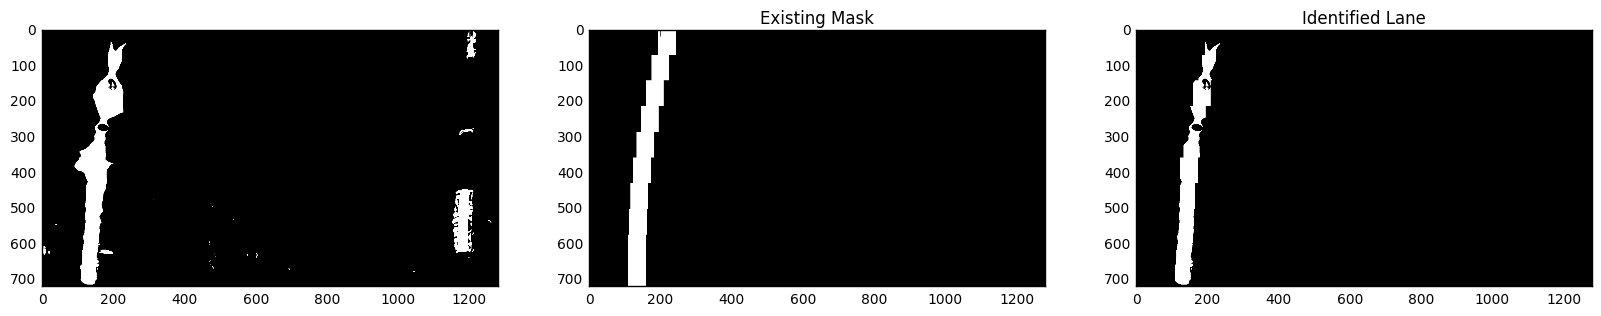

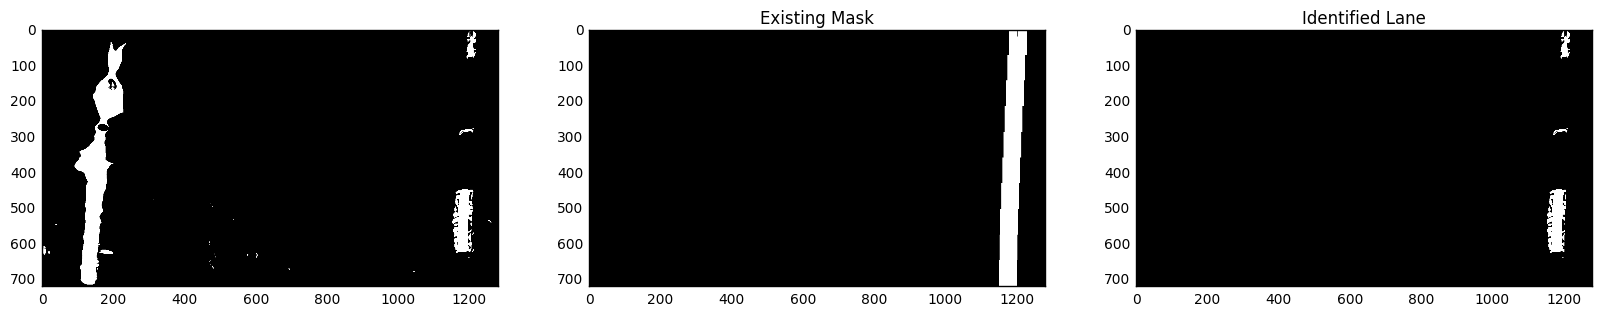

In [18]:
DEBUG = False
img = mpimg.imread('test_images/test5.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
img = get_birdeye_view(img) 
img, _, _, _ = pipeline(img)

DEBUG = True
# Test identify lane from existing
_ = identify_lane_from_existing(img, lane_record = record_left_lane)
_ = identify_lane_from_existing(img, lane_record = record_right_lane)

Plot back to original space

In [19]:
def draw_lanes_image(image, birdeye_img, record_left_lane, record_right_lane):

    if (record_left_lane is None or record_right_lane is None or record_left_lane.best_fit is None or record_right_lane.best_fit is None):
        if DEBUG:
            print('Cannot draw_lanes_image since one is None')
        return image
    
    yvals = np.arange(11)*img_size[0]/10
    left_fitx = record_left_lane.best_fit[0]*yvals**2 + record_left_lane.best_fit[1]*yvals + record_left_lane.best_fit[2]
    right_fitx = record_right_lane.best_fit[0]*yvals**2 + record_right_lane.best_fit[1]*yvals + record_right_lane.best_fit[2]
    
    # image: undistorted original image
    img = cv2.resize(image, dsize = (img_size[1], img_size[0]))

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(birdeye_img).astype(np.uint8)
    color_warp = np.dstack((birdeye_img, birdeye_img, birdeye_img))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # write_image(color_warp, 'output_images/fit_poly.jpg')   
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[1], img_size[0])) 
    newwarp = newwarp.astype(np.uint8)

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    # write_image(result, 'output_images/fit_poly_original_space.jpg') 
    
    return result



In [20]:
record_left_lane = Line()
record_right_lane = Line()

debug = False

def full_pipeline(image):
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    if DEBUG:
        plt.imshow(undistorted_image)
        plt.show()
    
    birdeye_view = get_birdeye_view(undistorted_image) 
    
    if DEBUG:
        plt.imshow(birdeye_view)
        plt.show()
        
    result_pipeline, result_pipeline_yw, result_pipeline_sobel, result_pipeline_sobel_V  = pipeline(birdeye_view) # it will change color spaces etc.

    if DEBUG:
        plt.imshow(result_pipeline)
        plt.show()
    
    right_fit, rightyvals, rightx, is_hist_right = identify_lane(result_pipeline, lane = 'right', lane_record = record_right_lane)
    left_fit, leftyvals, leftx, is_hist_left = identify_lane(result_pipeline, lane = 'left', lane_record = record_left_lane)

    left_curverad_meters, left_line_position_px = get_curb(left_fit, leftyvals, leftx)
    right_curverad_meters, right_line_position_px = get_curb(right_fit, rightyvals, rightx)

    ignore_frame_left_ratio, ignore_frame_right_ratio = False, False
    ratio_left_right = None
    if left_curverad_meters is not None and right_curverad_meters is not None:
        ratio_left_right = 1. * left_curverad_meters / right_curverad_meters
        if (record_left_lane.framect > 0 and ratio_left_right > _MAX_RADIUS_RATIO_):
            ignore_frame_left_ratio = True
        if (record_left_lane.framect > 0 and 1.0 / ratio_left_right > _MAX_RADIUS_RATIO_):
            ignore_frame_right_ratio = True
    
    ignore_frame_left = update_lane_info(record_left_lane, left_fit, left_curverad_meters, left_line_position_px, leftyvals, leftx, ignore_frame_left_ratio)
    ignore_frame_right = update_lane_info(record_right_lane, right_fit, right_curverad_meters, right_line_position_px, rightyvals, rightx, ignore_frame_right_ratio)
    
    result = draw_lanes_image(undistorted_image, result_pipeline, record_left_lane = record_left_lane, record_right_lane = record_right_lane)

    # plot the left and right lane points found
    graph = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)
    for i in range(len(rightyvals)):
        graph[rightyvals[i], rightx[i]][0] = 255
    for i in range(len(leftyvals)):
        graph[leftyvals[i], leftx[i]][1] = 255
    
    # write_image(graph, 'output_images/identify_lanes_both_lanes_pixels.jpg')
    
    car_from_middle = get_car_from_middle(record_left_lane, record_right_lane)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    if (record_left_lane.radius_of_curvature is not None and record_right_lane.radius_of_curvature is not None):
        cv2.putText(result, "Left Radius: " + str(int(record_left_lane.radius_of_curvature)) + "m", 
                    (10, 30), font, 1, (255,255,0), 2)
        cv2.putText(result, "Right Radius: " + str(int(record_right_lane.radius_of_curvature)) + "m", 
                    (10, 70), font, 1, (255,255,0), 2)
            
    cv2.putText(result, "Distance from car to center of road: " + str(round(car_from_middle,2)) +  "m", 
                (10, 110), font, 1, (255,255,0), 2)    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = np.zeros((120, 1280, 3), dtype=np.uint8) 
    cv2.putText(text, "Yellow/White", (0, 30), font, 1, (255,0,0), 2)
    cv2.putText(text, "L magn/dir", (320, 30), font, 1, (255,0,0), 2)
    cv2.putText(text, "L magn/dir + V", (640, 30), font, 1, (255,0,0), 2)
    cv2.putText(text, "Binary Output", (960, 30), font, 1, (255,0,0), 2)

    # assemble the screen example
    images_video = np.zeros((1080, 1920, 3), dtype=np.uint8)
    images_video[0:720, 0:1280] = result
    images_video[0:240, 1280:1600] = cv2.resize(image, (320,240), interpolation=cv2.INTER_AREA) 
    images_video[240:480, 1600:1920] = cv2.resize(birdeye_view, (320,240), interpolation=cv2.INTER_AREA)
    images_video[600:1080, 1280:1920] = cv2.resize(graph, (640,480), interpolation=cv2.INTER_AREA)
    images_video[720:840, 0:1280] = text
    images_video[840:1080, 0:320] = cv2.resize(np.stack((255*result_pipeline_yw, 255*result_pipeline_yw, 255*result_pipeline_yw), axis=2), (320,240), interpolation=cv2.INTER_AREA)
    images_video[840:1080, 320:640] = cv2.resize(np.stack((255*result_pipeline_sobel, 255*result_pipeline_sobel, 255*result_pipeline_sobel), axis=2), (320,240), interpolation=cv2.INTER_AREA)
    images_video[840:1080, 640:960] = cv2.resize(np.stack((255*result_pipeline_sobel_V, 255*result_pipeline_sobel_V, 255*result_pipeline_sobel_V), axis=2), (320,240), interpolation=cv2.INTER_AREA)
    images_video[840:1080, 960:1280] = cv2.resize(np.stack((255*result_pipeline, 255*result_pipeline, 255*result_pipeline), axis=2), (320,240), interpolation=cv2.INTER_AREA)
    
    return images_video 




test_images/frame25.jpg


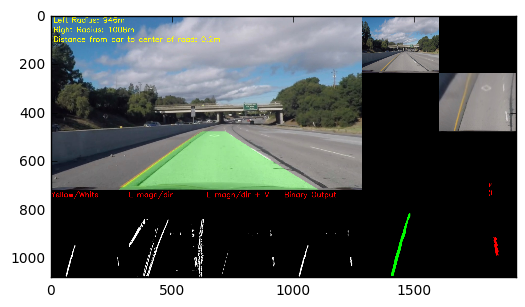

test_images/solidWhiteRight.jpg


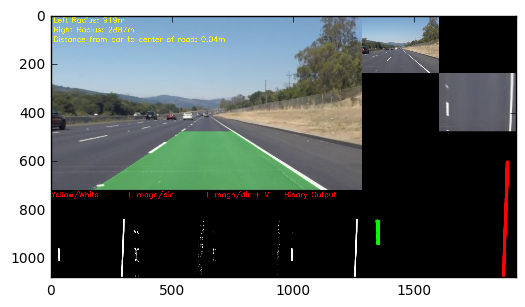

test_images/solidYellowLeft.jpg


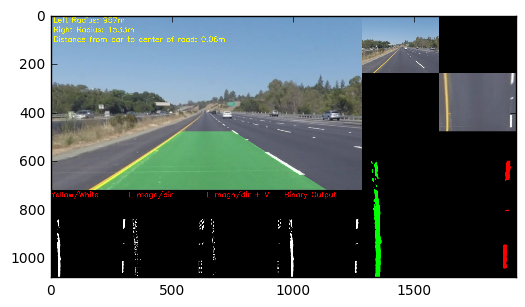

test_images/test1.jpg


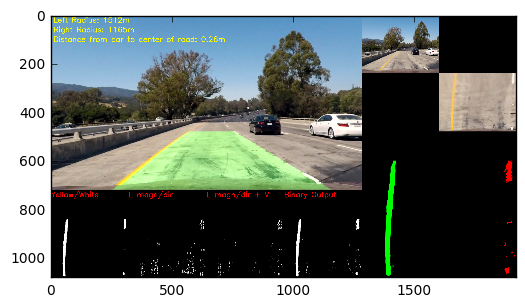

test_images/test2.jpg


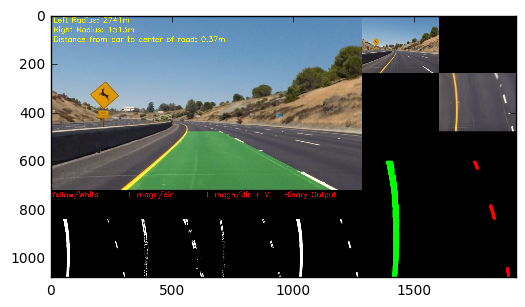

test_images/test3.jpg


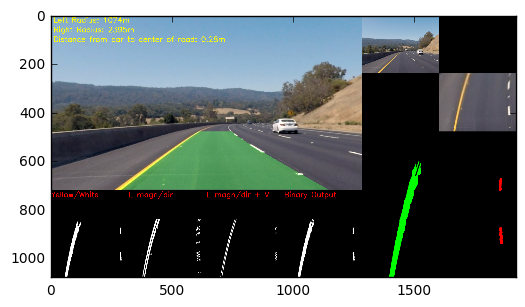

test_images/test4.jpg


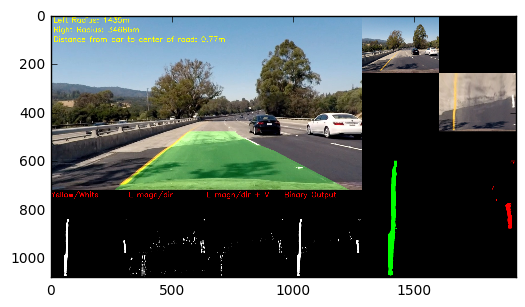

test_images/test5.jpg


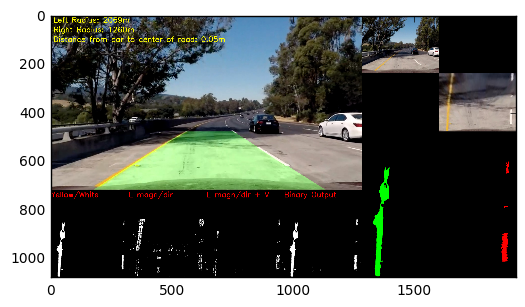

test_images/test6.jpg


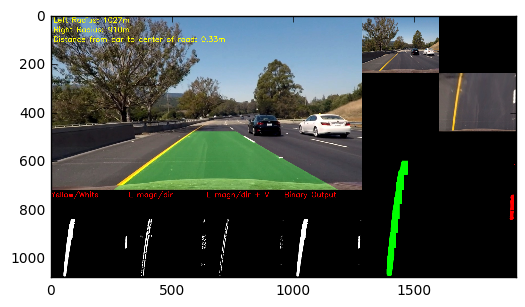

In [21]:
DEBUG = False

images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    print(fname)
    if True: #fname == 'test_images/test5.jpg':
        record_left_lane = Line()
        record_right_lane = Line()

        image = mpimg.imread(fname)

        result = full_pipeline(image)

        plt.imshow(result)
        plt.show()
    

### VIDEO

In [23]:
DEBUG = False
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
record_left_lane = Line()
record_right_lane = Line()
white_output = 'project-video-final.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(full_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project-video-final.mp4
[MoviePy] Writing video project-video-final.mp4


100%|█████████▉| 1260/1261 [07:54<00:00,  2.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project-video-final.mp4 

CPU times: user 7min 39s, sys: 2min, total: 9min 40s
Wall time: 7min 55s


In [ ]:
# Extract frame from video if necessary
# Import the necessary packages
# import argparse
# import cv2

# vidcap = cv2.VideoCapture("challenge4.mp4")
# success,image = vidcap.read()
# count = 0;
# while count < 10:
#     success,image = vidcap.read()
#     if count == 7:
#         cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
#     count += 1